# Module of logarithmic vector fields $D(A)$ of a central arrangement $A$

- Created: 6 June 2023
- Last modifed: 7 December 2023


TODO

- Follow the SAGE style: https://doc.sagemath.org/html/en/developer/coding_basics.html#documentation-strings
- Make a package: https://doc.sagemath.org/html/en/developer/index.html#packaging


In [1]:
!pip install -q tqdm

## Function definition
First, execute the cells under this section to define necessary functions

### main functions

In [2]:
# sage functions
from sage.rings.polynomial.toy_variety import linear_representation
from sage.matrix.args import MatrixArgs
from sage.structure.element import is_Vector
from sage.libs.singular.function_factory import singular_function
from sage.modules.free_module_element import FreeModuleElement_generic_dense as module_elem
minbase = lambda L:singular_function('minbase')(Sequence(L))
syz = singular_function("syz")
groebner = singular_function("groebner")

# python libraries
import itertools
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.axes_grid1

class HyperPlaneArr():
    r"""
    The main class for the logarithmic derivation module of a central arrangement.

    INPUT:

    - ``mat`` -- matrix or list; a `p \times n' matrix whose row vectors correspond to the linear forms defining the planes
    - ``Q`` -- polynomial (default: `None`); the defining polynomial of an arrangement that is the product of all linear forms defining the planes
    - ``base_field`` -- field (default: `QQ`); Base field for the ambient space. Used only when the arrangement is specified by a list or an array

    ATTRIBUTES:
    - ``mat``: a matrix whose row vectors correspond to the linear forms defining the planes
    - ``K``: the base field
    - ``n``: the dimension of the ambient space V
    - ``v``: the generators [v[0],...,v[n-1]] of V^*
    - ``S``: the base polynomial ring K[v[0],...,v[n-1]]
    - ``Q``: the defining polynomial
    - ``jacob_I``: the Jacobian ideal of Q
    - ``minimal_generators``: the list of minimal generators of the logarithmic derivation module D(A)
    - ``euler``: the Euler derivation
    """
    
    def __init__(self, mat=None, *, multiplicity=None, Q=None, base_field=QQ):
        if mat is not None and Q is None:
            # arrangement from matrix
            if isinstance(mat,sage.matrix.matrix0.Matrix):
                self.mat = mat
            else:
                self.mat = matrix(base_field, mat)
            if not is_distinct_planes(self.mat):
                raise ValueError('the given arrangement contains duplicated planes!')
            self.K = self.mat.base_ring()
            self.n = self.mat.ncols()
            self.S = PolynomialRing(self.K, 'x', self.n)
            self.v = self.S.gens()
            self.Q = mul([sum(u[j]*self.v[j] for j in range(self.n)) for u in self.mat.rows()]) # defining polynomial
        elif mat is None and Q is not None:
            # arrangement from the defining polynomial
            self.Q = Q
            self.S = Q.parent()
            self.v = self.S.gens() 
            self.K = self.S.base_ring()
            self.n = len(self.v)
            try:
                QF = factor(Q)
            except:
                QF = Q
            B = []
            for linear_factor,exponent in QF: 
                assert exponent==1 ## assuming QF is square-free
                B.append([linear_factor.coefficient(self.v[i]) for i in range(self.n)])
            self.mat = matrix(self.K,B)
        else:
            raise ValueError('provide either matrix ``mat`` or defining polynomial ``Q``.')

        ## parameters
        self.multiplicity = multiplicity
        self.euler = vector(self.v) # Euler derivation
        self.SPOG = None # True, if the arramgenet is SPOG. Computed when self.is_SPOG() is called
        self.num_planes = self.mat.nrows() # number of hyperplanes in the arrangement
        
        # compute minimal generators of D(A) by D(A) \cong <Euler> \oplus Syz(J_Q) 
        self.jacob_I = ideal(*[self.Q.derivative(self.v[j]) for j in range(self.n)]) # Jacobian ideal of Q
        self.minimal_generators = [self.euler]+[self.euler_complement(u) for u in minbase(self.jacob_I.syzygy_module())] # vector(v) is the Euler derivation
        self.degs = degseq(self.minimal_generators) # derivation degree sequence
        self.is_free = (len(self.degs)==self.n) # True, if the arrangement is free
        self.linear_forms = [sum(self.mat[i,j]*self.v[j] for j in range(self.n)) for i in range(self.num_planes)] # list of linear forms defining the planes

    def is_in_DA(self,gv):
        # check if an element `gv` of S^n is in D(A)
        for i in range(self.num_planes):
            gva = sum([self.mat[i,j]*gv[j] for j in range(len(gv))])
            if not gva in ideal(self.linear_forms[i]):
                return(False)
        return(True)

    def compute_multi_minimal_generators(self):
        S1 = self.S^1
        M=[]
        for alpha,m in zip(self.linear_forms,self.multiplicity):
            RM=Sequence([module_elem(S1, (alpha.derivative(self.v[j]),)) for j in range(self.n)]+[module_elem(S1,(alpha^m,))])
            M.append(matrix([u[:-1] for u in syz(RM)]))
        return(list(module_intersection(M)))        
        
    def free_resolution(self):
        # compute free resolution of D(A)
        M = self.minimal_generators[0].parent()
        return(M.submodule(self.minimal_generators).graded_free_resolution())

    def euler_complement(self,g,alpha=None):
        # decompose S^n into a direct sum of <euler> + D_0(A) 
        if alpha is None:
            ag = self.v[-1]
        elif is_Vector(alpha):
            ag = self.euler.dot_product(alpha)
        elif type(alpha)==Integer:
            ag = self.v[alpha]  
        return(g-ag(*g)//ag*self.euler)

    def restriction(self,i):
        # restriction of A with respect to i-th hyperplane
        B=copy(self.mat)
        piv = np.where(np.array(B[i])!=0)[0][0] # first non-zero coord
        for t in range(B.nrows()):
            B[t] = self.mat[i,piv]*B[t]-B[t,piv]*self.mat[i]
        B = B.delete_columns([piv]).delete_rows([i])
        B, multiplicity = remove_duplicate_planes(B)
        for t in range(B.nrows()):
            B[t] /= gcd(B[t])
            c = np.where(np.array(B[t])!=0)[0][0]
            B[t] *= sgn(B[t,c])
        return(HyperPlaneArr(B,multiplicity=multiplicity))
    
    def localisation(self,L):
        ## localisation of A at X = \cap_{i\in L} A_i
        I = Ideal(*[a.dot_product(self.euler) for a in self.mat[L,:]])
        indices = []
        for i,a in enumerate(self.mat):
            if a.dot_product(self.euler) in I:
                indices.append(i)
        return(HyperPlaneArr(self.mat[indices,:]))

    def deletion(self,L):
        ## delete planes of A at indices specified by L
        return(HyperPlaneArr(self.mat.delete_rows(L)))

    def addition(self,mat):
        if isinstance(mat,list):
            return(HyperPlaneArr(self.mat.stack(vector(mat))))
        else:
            return(HyperPlaneArr(self.mat.stack(mat)))

    def intersection_lattice(self):
        #TODO
        return(None)
        
    def is_SPOG(self):
        # check if the arrangement is SPOG(strictly plus-one generated).
        # if it is, returns degrees (exponents with level as the last element)
        self.SPOG = False
        fr=self.free_resolution()
        if fr._length != 2:
            return(False)
        if len(fr.betti(2)) != 1: # there should be only a single relation
            return(False)
        for deg, multiplicity in fr.betti(2).items(): # relations
            if multiplicity != 1:
                return(False)
            else:
                level = deg-1
        if level not in fr.betti(1).keys(): # the relation should be in degree level+1
            return(False)
        degs = []
        for deg, multiplicity in fr.betti(1).items(): # generators
            if deg==level:
                degs.extend([deg]*(multiplicity-1))
            else:
                degs.extend([deg]*multiplicity)
        self.SPOG = True
        return(sorted(degs)+[level])

    def level_coeff(self):
        # returns level coefficient and level element
        if self.SPOG is None:
            self.is_SPOG()
        if not self.SPOG:
            raise ValueError('the given arrangement is not SPOG.')
        MG = self.minimal_generators
        u = MG[0]
        RM=Sequence([module_elem(self.S**self.n,tuple(MG[i])) for i in range(len(MG))])
        LHS = None
        RHS = []
        #print(syz(RM))
        for g in syz(RM):
            if 1 in [m.degree() for m in g]: # find degree one
                for i,m in enumerate(g):
                    if LHS is None and m.degree()==1:
                        LHS = (m,i,MG[i])
                    elif m!=0:
                        RHS.append((-m,i,MG[i]))
        return(LHS,RHS)
                
    # search for a free addition: experimental
    def search_free_addition(self,a_range=range(-10,10),b_range=range(-10,10)):
        plane = None
        found = False
        for a in tqdm(a_range):
            if found:
                break
            for b in b_range:
                if found:
                    break
                for c in [0,1]:
                    plane=[c,a,b]+[0]*(self.n-3)
                    try:
                        B=self.addition(plane)
                    except:
                        continue
                    if B.is_free:
                        print("plane: ",vector(plane),"degrees: ",B.degs)
                        found=True
                        break
        if not found:
            print("No planes found")
        return(plane)

    def plot_arr(self,xlim=None,ylim=None,ax=None,levels=0,nx=100,ny=100,legend=True,offset = 5):
        # plot arrangement
        ## (TODO): how to draw the line at infinity?
        if self.n not in [2,3]:
            raise ValueError('plot works only for two or three dimensional arrangements')
        if ax is None:
            fig, ax = plt.subplots(1,1)
        ax.set_aspect('equal')
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        latex_str=[latex(s) for s in self.linear_forms]
        for i in range(self.num_planes):
            l = self._line_ends(self.mat[i],xlim=xlim,ylim=ylim)
            if l is not None:
                ax.axline(*l,label=f'${latex_str[i]}$')
                #print(latex_str[i],l[1])
                if legend:
                    ax.annotate(f'${latex_str[i]}$',l[1],xytext=(-offset, -1.5*offset), textcoords='offset points')
    
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        # plot contours of Q
        if levels>0:
            px = np.linspace(xlim[0],xlim[1],nx)
            py = np.linspace(ylim[0],ylim[1],ny)
            xv, yv = np.meshgrid(px, py)
            Z = []
            if self.n==3:
                for x,y in zip(xv.ravel(),yv.ravel()):
                    Z.append(self.Q(Rational(x),Rational(y),1))   
                    #Z.append(Q(Rational(y),1,Rational(x)))    
            elif self.n==2:
                for x,y in zip(xv.ravel(),yv.ravel()):
                    Z.append(self.Q(Rational(x),Rational(y)))
            Z = np.array(Z).reshape(*xv.shape)
            ax.contour(px,py,Z,levels=levels)        
        ##
        Qstr = "".join([f"({x})" for x in latex_str])
        ax.set_title(f'${Qstr}$')
        # if legend:
        #     plt.legend(loc='upper left', bbox_to_anchor=(1, 1.0),fancybox=True, shadow=True)
        plt.axis('off')
        return(ax)
            
    def _line_ends(self,alpha,xlim=None,ylim=None):
        # find end points of the line defined by a linear form alpha
        if xlim is None:
            xlim=(-1,1)
        if ylim is None:
            ylim=(-1,1)
        if len(alpha)==2:
            a,b = alpha
            c = 0
        else:
            a,b,c = alpha
        if (a==0 and b==0):
            return(None)
        if (a*b !=0) and ((-c-a*xlim[1])/b < ylim[0] or (-c-a*xlim[1])/b > ylim[1]):
            xlim = (xlim[0], -(b*ylim[0]+c)/a)
        return [(-c/a,q) if b==0 else (p,(-c-a*p)/b) for p,q in zip(xlim,(ylim[1],ylim[0]))]
    
    # plot an element u of D(A) as a vector field (works only for n=2,3)
    def plot_vfield(self, u, quiver=True, cmap="coolwarm", nx=30,ny=30, scale = None, xlim=None, ylim=None, ax=None):
        if self.n not in [2,3]:
            raise ValueError('plot works only for two or three dimensional arrangements')
        ax = self.plot_arr(xlim,ylim,ax=ax)
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
    
        px = np.linspace(xlim[0],xlim[1],nx)
        py = np.linspace(ylim[0],ylim[1],ny)
        xv, yv = np.meshgrid(px, py)
        vx,vy = [],[]
        if len(u)==3:
            u_c = self.euler_complement(u,-1)
            for x,y in zip(xv.ravel(),yv.ravel()):
                vx.append(u_c[0](Rational(x),Rational(y),1))        
                vy.append(u_c[1](Rational(x),Rational(y),1))
        else:
            u_c = u
            for x,y in zip(xv.ravel(),yv.ravel()):
                vx.append(u[0](Rational(x),Rational(y)))        
                vy.append(u[1](Rational(x),Rational(y)))
            
        vx = np.array(vx).reshape(*xv.shape)
        vy = np.array(vy).reshape(*yv.shape)
        mgn = (np.sqrt(vx*vx+vy*vy))
        if quiver:
            strm = ax.quiver(xv,yv,vx,vy,mgn,cmap=cmap,scale=scale)#,scale_units='width',width=0.005)
        else:
            strm = ax.streamplot(xv, yv, vx,vy, color=mgn, linewidth=2, cmap=cmap, density=[float(0.5),float(1.)])
        ax.set_title(f'${latex(u_c)}$')
        ax.set_aspect('equal')
        ax.axis('off')
        return(ax)
    
# convert vector representation of elements in S^n to a linear combination of partial_i
def vec2d(u):
    if type(u) is list:
        return(list(map(vec2d,u)))
    else:
        S = u.parent().base_ring()
        K=S.base_ring()
        v= S.gens()
        PD = PolynomialRing(K,'d',len(v))
        FM = K[v+PD.gens()]
        d=FM.gens()[len(v):]
        return(sum(u[j]*d[j] for j in range(len(v))))

# convert a linear combination of partial_i to a vector representation in S^n
def d2vec(u):
    if type(u) is list:
        return(list(map(d2vec,u)))
    else:
        gens = u.parent().gens()
        d = gens[(len(gens)//2):]
        vec = []
        for i in range(len(d)):
            subs_d = {d[j]:0 for j in range(len(d))}
            subs_d[d[i]] = 1
            vec.append(u.subs(subs_d))
        return(vector(vec))

# arrange generators w.r.t. degrees
def gendic(MG):
    MGs={}
    for g in MG:
        deg = max(m.degree() for m in g)
        if deg in MGs.keys():
            MGs[deg].append(g)
            #MGs[deg].append(vec2d(g))
        else:
            MGs[deg] = [g]
    return(MGs)

# degree sequence
def degseq(MG):
    return(sorted([max(m.degree() for m in g) for g in MG]))

# check if all the planes are distinct
def is_distinct_planes(mat):
    for plane in itertools.combinations(range(mat.nrows()),2):
        if mat[plane,:].rank()<2:
            return(False)
    return(True)

# remove duplicate planes
def remove_duplicate_planes(mat):
    # TODO: make it more efficient by normalising all vectors and select unique elements
    indices = list(range(mat.nrows()))
    K=mat.base_ring()
    n=mat.ncols()
    # first, remove zero plane
    zerovec = zero_vector(K,n)
    for plane in indices:
        if mat[plane]==zerovec:
            indices.remove(plane)
    multiplicity = [1]*len(indices)
    for pair in itertools.combinations(indices,2):
        if (pair[1] in indices) and (mat[pair,:].rank()<2):
            indices.remove(pair[1]) # remove the one with a larger index
            multiplicity[pair[0]] += 1
    return(mat[indices,:], [multiplicity[i] for i in indices])

# coordinate vectors
def coord_vec(n):
    return(list(np.eye(n)))

## check if elements of S^n are S-independent
def is_S_indep(MG):
    return(det(saito(MG))!=0)
    
## The matrix in Saito's criterion
def saito(MG):
    assert len(MG[0])==len(MG) # the number of generators == n
    M=matrix(MG)
    return(M)

## compute the intersection of two modules
def module_intersection(Ms):
    Mint = Ms[0].transpose()
    for M in Ms[1:]:
        Mint = singular.intersect(Mint,M.transpose())
        #Mint = Mint.sage()  ## to void a bug of misidentifing the base ring...
    return singular.minbase(Mint).sage().transpose()

# experimental
import sage.parallel.multiprocessing_sage
def list_ntf2(i,A=None):
    results={}
    B=A.deletion([i])
    if B.is_free:
        print(f"del {i} is free",B.degs)
    else:
        C=A.restriction(i)
        print(f"Res to {i} free?: {C.is_free}")
        for j in range(i+1,A.num_planes):        
            B=A.deletion([i,j])
            results[(i,j)]=B.degs
            if B.is_SPOG():
                #LHS,RHS = B.level_coeff()
                print('SPOG:',(i,j),B.degs)#, f"level coeff: {LHS[0]}")
            elif B.is_free:
                print('free: ',(i,j),B.degs)
            else:
                st = f"pd={len(B.free_resolution())-1}"
                print(st,(i,j),B.degs)
    return(results)
    
# version
print(sage.version.banner)

SageMath version 10.0, Release Date: 2023-05-20


### linear algebraic algorithm

In [3]:
# computation of D(A) by linear algebraic methods

# matrices representing the multiplication by x[i]: S_k to S_{k+1}
# faster than coef_map2 and works for any characteristic
def coef_map(k,S):
    v=S.gens()
    K=S.base_ring()
    n=len(v)
    Sk_list=Sk_expo(k,n)
    Sk1_list=Sk_expo(k+1,n)
    Sk1_dic = {ex:i for i,ex in enumerate(Sk1_list)}
    Mi=[[] for i in range(n)]
    eye = np.eye(n)
    for i,expo in enumerate(Sk_list):
        for j in range(n):
            e = np.array(expo)+eye[j]
            Mi[j].append((i,Sk1_dic[tuple(e)]))
    M = [MatrixArgs(K,len(Sk_list),len(Sk1_list),entries={k:1 for k in Mi[j]}).matrix() for j in range(n)]
    return(M,[expo2poly(expo,v) for expo in Sk1_list])

# not used currently
def coef_map2(k,S): #S_k到S_k+1的系数矩阵, coefficient_matrix of linear map from S_k to S_k+1
    v=S.gens()
    f=((sum(v))^k)
    Sk = f.monomials() #S_k的基向量，basis of vector space S_k
    Sk1 = (sum(v)*f).monomials() 
    M=[]                 #M[i]: coefficient_matrix of linear map of product v[i]
    for i in range(n):
        e1=(v[i]*f).monomials() #S_k的基向量*x_i，basis of vector space S_k product x_i
        M.append(matrix([linear_representation(e1[j],Sk1) for j in range(len(e1))]))
    return  M,Sk1

# enumerate all exponents of monomials in Sk
def Sk_expo(k,n): # can we find better indexing?
    Sk_list = []
    ones = np.ones(n,dtype=int)
    for e in Compositions(k+n,length=n):
        Sk_list.append(tuple(np.array(e)-ones))
    return(Sk_list)

# convert a list of exponents to a polynomial in indeterminants v[]
def expo2poly(Ls,v):
    if type(Ls) is list:
        u = 0
        for L in Ls:
            m = v[0]^0
            for i in range(len(L)):
                m *= v[i]^L[i]
            u += m
        return(u)
    else:
        return(expo2poly([Ls],v))


# image of lambda_i of V, a list of vector representations of elements of S^n
def image_lambda(V,n):
    k = max([V[0][j].degree() for j in range(n)])
    Sk1_list=Sk_expo(k+1,n)
    Sk1_dic = {e:i for i,e in enumerate(Sk1_list)}
    eye = np.eye(n,dtype=int)
    M=[]
    L={}
    num = 0
    for u in V:
        for j in range(n):  # times v[j]
            for i in range(n): # each exponent           
                for e,c in u[i].dict().items():
                    le = tuple(np.array(e[:n])+eye[j])
                    L[Sk1_dic[le]*n+i,num] = c
            num += 1
    M = MatrixArgs(QQ,len(Sk1_dic)*n,len(V)*n,entries=L).matrix()
    return(M)

# convert a list of elements in S^k to a list of flattened vectors of dim=dim(Sk)*n
def vec2flatten(U,Sk_dic):
    L={}
    n = len(list(Sk_dic.keys())[0])
    for j,u in enumerate(U):
        for i in range(n):            
            for e,c in u[i].dict().items():
                L[Sk_dic[tuple(e[:n])]*n+i,j] = c
    M = MatrixArgs(QQ,len(Sk_dic)*n,len(U),entries=L).matrix()
    return(M)    
        
# vector basis of D(A) of degree k+1
def gener_sk(mat,k):
    p=mat.nrows()
    n=mat.ncols()
    K=mat.base_ring()
    S=PolynomialRing(K, 'x', n)
    M,Sk1=coef_map(k,S)#M:coefficient_matrix,Sk1:basis of S_k+1
    m1=binomial(n+k-1, k)#dimension of S_k
    m2=len(Sk1)#dimension of S_k+1
    C=zero_matrix(K,n*m2+p*m1,p*m2)#coefficient_matrix of XC=0, where X_1(A[i])+A[i]*X_2 = 0 
    for i in range(p):# C[i] is the coefficient_matrix of derivation equation of i-th hyperplane 
        D=zero_matrix(K,n*m2+p*m1,m2) #C[i]==D
        Y = sum([mat[i,j]*M[j] for j in range(n)]) # matrix for multiplication by A[i]
        D[(n*m2+i*m1):(n*m2+(i+1)*m1),:]=Y
        for j in range(m2):
            D[j*n:(j+1)*n,j]=mat[i,:].transpose()
        C[:,i*m2:(i+1)*m2]=D
    B=kernel(C.sparse_matrix()).matrix()#solution space of XC=0
    #B=kernel(C).matrix()#solution space of XC=0
    B=B[:,:n*m2]# each row is the coordinate of a derivation, and they are linearly independent
    Gener=[] # K-linear basis for D(A) of degree k+1
    for i in range(B.nrows()):
        if B[i]!=0:
            E=sum(Sk1[j]*B[i,j*n:(j+1)*n] for j in range(m2))
            Gener.append(vector(E))
    return Gener


# find the minimal set of homogeneous generators given any generating set of a submodule of S^n
## for the homogeneous case, use minbase, which is more efficient
def minimal_generating_set(G):
    if len(G)==0:
        return([])
    S = G[0].parent().base_ring()
    v = S.gens()
    K=S.base_ring()
    PD = PolynomialRing(K,'d',len(v))
    FM = K[v+PD.gens()]
    d=FM.gens()[len(v):]
    G = sorted(G,key=lambda x:x.degree()) #  sort G in the increasing order w.r.t. degree
    r = [d[i]*d[j] for i in range(len(v)) for j in range(i,len(v))] # relations among partial_i
    MG = []
    MG_index = []
    I = ideal(*r,*MG)
    for i in range(len(G)):        
        g = vec2d(G[i])
        if g not in I:
            MG.append(g)
            MG_index.append(i)
            I = ideal(*r,*MG)
    return([G[i] for i in MG_index])


# find the minimal set of homogeneous generators for D(A)
def min_gen_arr(mat,verbose=True):
    if not is_distinct_planes(mat):
        raise ValueError('the given arrangement contains duplicated planes!')
    p=mat.nrows()
    n=mat.ncols()
    K=mat.base_ring()
    S=PolynomialRing(K, 'x', n)
    v = S.gens()
    PD = PolynomialRing(K,'d',len(v))
    FM = K[v+PD.gens()]
    d=FM.gens()[len(v):]
    
    if verbose:
        print(f'num of planes is {p}')
    r = [d[i]*d[j] for i in range(len(v)) for j in range(i,len(v))] # relations among partial_i
    GEN=[]
    GEN_vec = []
    degs=[]
    for k in range(p-n+2):
        # check Saito's criterion
        if sum(degs[:len(v)-1])+k<p<sum(degs):
            flag_skip = False
            for comb in itertools.combinations(degs, len(v)-1):
                if sum(comb)+k+1==p:
                    flag_skip = True
            if flag_skip:
                print(f"skipping deg {k+1} by Saito's criterion")
                continue
        # generate module basis
        G=gener_sk(mat,k)
        if verbose:
            print(f'number of vector generators at deg {k+1} is {len(G)}')
        I = ideal(*r,*GEN)
        for i in range(len(G)):
            g = vec2d(G[i])
            if g not in I:
                GEN.append(g)
                GEN_vec.append(G[i])
                I = ideal(*r,*GEN)
                degs.append(k+1) # degree sequence
                if len(degs)==len(v) and sum(degs)==p: # given the freeness of arrangement by Saito's criterion 
                    if verbose:
                        print('free')
                        print('degree sequence: ',degs)
                    return(GEN_vec)
    if verbose:
        print('degree sequence: ',degs)
    return(GEN_vec)

# find minimal set of homogeneous generators by row echelon form
def min_gen_arr_linear(mat,max_k=None,verbose=True):
    p=mat.nrows()
    n=mat.ncols()
    if max_k is not None:
        mk = max_k
    else:
        mk = p-n+1
    K=mat.base_ring()
    S=PolynomialRing(K, 'x', n)
    v = S.gens()
    V = gener_sk(mat,0)
    if verbose:
        print(f'deg 1, num gens {len(V)}')
    MG=V
    for k in range(mk-1):
        M = image_lambda(V,n)
        V = gener_sk(mat,k+1)
        Sk1_list=Sk_expo(k+2,n)
        Sk1_dic = {e:i for i,e in enumerate(Sk1_list)}
        Sk1=[expo2poly(expo,v) for expo in Sk1_list]
        V1 = vec2flatten(V,Sk1_dic)
        lDk1 = M.augment(V1)
        piv=np.array(lDk1.pivots())
        mask = piv>=M.ncols()
        MG.extend([vector(sum(Sk1[j]*lDk1[j*n:(j+1)*n,i] for j in range(len(Sk1)))) for i in piv[mask] ])
        if verbose:
            print(f'deg {k+2}, dim {len(V)}, codim {n*binomial(n+k, k+1)-len(V)}, num new gen {sum(mask)}')
    return(MG)


# Examples
This section illustrates the main functionality of the code by examples

## dim 3, |A|=3, free

In [4]:
# an arrangement is represented by a matrix whose row vectors correspond to the linear forms defining the planes
A=HyperPlaneArr([[1,0,0],[0,1,0],[0,0,1]],base_field=QQ)
# minimal set of generators
print(A.minimal_generators)
# degree sequence of D(A)
print(A.degs)

[(x0, x1, x2), (x0, 2*x1, 0), (2*x0, x1, 0)]
[1, 1, 1]


In [5]:
# alternatively
MG=min_gen_arr(A.mat,verbose=True)
vec2d(MG)

num of planes is 3
number of vector generators at deg 1 is 3
free
degree sequence:  [1, 1, 1]


[x0*d0, x1*d1, x2*d2]

In [6]:
# Free resolution
res=A.free_resolution()
print(ascii_art(res.chain_complex()))
res

            [x0  0  0]      
            [ 0 x1  0]      
            [ 0  0 x2]      
 0 <-- C_0 <----------- C_1 <-- 0 


S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-1)⊕S(-1) <-- 0

In [7]:
# define arrangement by the defining polynomial
R.<x,y,z> = QQ['x,y,z']
A=HyperPlaneArr(Q=x*y*z)
print(A.mat)
A.minimal_generators

[0 0 1]
[0 1 0]
[1 0 0]


[(x, y, z), (x, 2*y, 0), (2*x, y, 0)]

## dim 3, |A|=4, non-free, SPOG

In [8]:
# the default base field is QQ
A=HyperPlaneArr([[1,0,0],[0,1,0],[0,0,1],[1,1,1]])
gendic(A.minimal_generators)

{1: [(x0, x1, x2)],
 2: [(4*x0*x1, 4*x1^2 + 4*x1*x2, 0),
  (x0^2 + 2*x0*x1 + x0*x2, 2*x0*x1 + 3*x1^2 + 3*x1*x2, 0),
  (3*x0^2 - 2*x0*x1 + 3*x0*x2, 2*x0*x1 - 3*x1^2 - 3*x1*x2, 0)]}

In [9]:
# we can define the arrangement also by the defining polynomial
R.<x,y,z> = QQ['x,y,z']
A=HyperPlaneArr(Q=x*y*z*(x+y+z))
A.minimal_generators

[(x, y, z),
 (4*x*y, 4*y^2 + 4*y*z, 0),
 (x^2 + 2*x*y + x*z, 2*x*y + 3*y^2 + 3*y*z, 0),
 (3*x^2 - 2*x*y + 3*x*z, 2*x*y - 3*y^2 - 3*y*z, 0)]

In [10]:
# check if generators are indeed in D(A)
for gv in A.minimal_generators:
    print(gv,A.is_in_DA(gv))

(x, y, z) True
(4*x*y, 4*y^2 + 4*y*z, 0) True
(x^2 + 2*x*y + x*z, 2*x*y + 3*y^2 + 3*y*z, 0) True
(3*x^2 - 2*x*y + 3*x*z, 2*x*y - 3*y^2 - 3*y*z, 0) True


In [11]:
# Free resolution
res=A.free_resolution()
print(ascii_art(res.chain_complex()))
res

                                                                              
            [              x               0               0               0] 
            [              y x*y + y^2 + y*z            -y*z             y*z] 
            [              z               0             y*z       x*z + z^2] 
 0 <-- C_0 <------------------------------------------------------------------

      [     0]      
      [    -z]      
      [-x - z]      
      [     y]      
 C_1 <--------- C_2 <-- 0 


S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-2)⊕S(-2)⊕S(-2) <-- S(-3) <-- 0

In [12]:
# the column vectors of the first differential corresponds to the generators
MG=[vector(u) for u in res.differential(1).matrix().columns()]
print(MG)


[(x, y, z), (0, x*y + y^2 + y*z, 0), (0, -y*z, y*z), (0, y*z, x*z + z^2)]


In [13]:
# the second differential gives the relation between the generators
matrix(MG).T * res.differential(2).matrix()


[0]
[0]
[0]

In [14]:
# This is an example of SPOG
S = MG[0].parent().base_ring()
v = S.gens()

LHS,RHS=A.level_coeff()
print(LHS,"\n",RHS)
print(LHS[0]*LHS[2]-sum(c[0]*c[2] for c in RHS))


(x + 3*z, 1, (4*x*y, 4*y^2 + 4*y*z, 0)) 
 [(y + 3*z, 2, (x^2 + 2*x*y + x*z, 2*x*y + 3*y^2 + 3*y*z, 0)), (y - z, 3, (3*x^2 - 2*x*y + 3*x*z, 2*x*y - 3*y^2 - 3*y*z, 0))]
(0, 0, 0)


## $Q_IA_I = \bigcap_{i\in I} a_i A_i$

In [15]:
mat=[[ 1,  0,  0,  0],
[ 0,  1,  0,  0],
[ 0,  0,  1,  0],
[-1,  1,  0,  0],
[-1,  0,  1,  0],
[ 0, -1,  1,  0],
[ 0,  0,  0,  1],
[ 0,  1, -1,  1],
[-1,  1, -1,  1],
[ 0,  0, -1,  1]]
A=HyperPlaneArr(mat)
print(f"Num of planes: {A.num_planes}, Deg. Seq. {A.degs}")
A.free_resolution()


Num of planes: 10, Deg. Seq. [1, 3, 3, 3]


S(0)⊕S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-3)⊕S(-3)⊕S(-3) <-- 0

In [16]:
# compute intersection
I = [2,4,9]
M=[matrix([g * A.linear_forms[i] for g in A.deletion([i]).minimal_generators]) for i in I]
Mint = module_intersection(M)
#M01a = [g/(A.linear_forms[i]*A.linear_forms[j]) for g in module_intersection(matrix(M0),matrix(M1))]
M01=A.deletion(I).minimal_generators
degseq(M01),degseq(list(Mint)) # degree shift by |I|

([1, 2, 2, 2], [4, 5, 5, 5])

## Splitting the rank-one submodule generated by the Euler derivation

In [17]:
A=HyperPlaneArr([[1,0,0],[0,1,0],[0,0,1],[1,1,1]])
# make 0-th coordinate to vanish except for the euler derivation
G1 = [A.euler]+[A.euler_complement(g,0) for g in A.minimal_generators[1:]]
G1

[(x0, x1, x2),
 (0, 4*x1*x2, -4*x1*x2),
 (0, x0*x1 + x1^2 + 2*x1*x2, -x0*x2 - 2*x1*x2 - x2^2),
 (0, -x0*x1 - x1^2 - 6*x1*x2, -3*x0*x2 + 2*x1*x2 - 3*x2^2)]

## Ex4.36 of Orlik-Terao
free $\subset$ non-free $\subset$ free

In [113]:
#free
A=HyperPlaneArr(matrix(QQ,coord_vec(3)+[[1,1,-1],[1,1,0]]))
A.degs

[1, 2, 2]

In [20]:
#non-free
B = A.deletion([4])
B.degs

[1, 2, 2, 2]

In [114]:
#free
B = A.deletion([3])
B.degs

[1, 1, 2]

In [21]:
#free
C = B.deletion([3])
C.degs

[1, 1, 1]

## Restriction

In [20]:
A=HyperPlaneArr(matrix(QQ,[[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1],[1,1,1,1],[1,1,1,-1]]))
B=A.restriction(4) # restriction on the 4th plane
print(B.mat)
print(A.minimal_generators)
print(B.minimal_generators)

[1 1 1]
[1 0 0]
[0 1 0]
[0 0 1]
[(x0, x1, x2, x3), (0, -x1*x2, x1*x2, 0), (-x0*x1 + x0*x2, x0*x1 + 5*x1*x2, -x0*x2 - 5*x1*x2, 0), (-x0*x1 - 5*x0*x2, x0*x1 + 5*x1*x2, 5*x0*x2 - 5*x1*x2, 0), (x0^2*x2 + x0*x1*x2, x0*x1*x2 + x1^2*x2, 2*x0*x2^2 + 2*x1*x2^2 + x2^3 - x2*x3^2, 0), (x0^2*x1 + x0*x1^2, x0*x1^2 + x1^3 + 3*x1*x2^2 - x1*x3^2, 2*x0*x1*x2 + 2*x1^2*x2 - 2*x1*x2^2, 0), (x0^3 - x0*x1^2 + 2*x0^2*x2 + 2*x0*x1*x2 + 3*x0*x2^2 - x0*x3^2, x0^2*x1 - x1^3 + 2*x0*x1*x2 + 2*x1^2*x2 - 3*x1*x2^2 + x1*x3^2, 2*x0^2*x2 - 2*x1^2*x2 + 2*x0*x2^2 + 6*x1*x2^2 + 2*x2^3 - 2*x2*x3^2, 0)]
[(x0, x1, x2), (x0*x1, x1^2 + x1*x2, 0), (x0^2 + 2*x0*x1 + x0*x2, 2*x0*x1 + 3*x1^2 + 3*x1*x2, 0), (3*x0^2 - 2*x0*x1 + 3*x0*x2, 2*x0*x1 - 3*x1^2 - 3*x1*x2, 0)]


## Parametrised family of arrangements

In [116]:
#Ex: arr. is free iff b = -t
b=2
t2=3
for t in range(-5,5):
    try:
        A=HyperPlaneArr(coord_vec(3)+[[1,1,0],[b,0,1],[0,t,1],[0,t2,1]])
        res=A.free_resolution()
        print(f"t={t} free? {A.is_free}")
        print(res,"\n")
    except:
        print(f"t={t} contains duplicate planes")


t=-5 free? False
S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-3)⊕S(-4)⊕S(-4) <-- S(-5) <-- 0 

t=-4 free? False
S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-3)⊕S(-4)⊕S(-4) <-- S(-5) <-- 0 

t=-3 free? False
S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-3)⊕S(-4)⊕S(-4) <-- S(-5) <-- 0 

t=-2 free? True
S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-3)⊕S(-3) <-- 0 

t=-1 free? False
S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-3)⊕S(-4)⊕S(-4) <-- S(-5) <-- 0 

t=0 contains duplicate planes
t=1 free? False
S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-3)⊕S(-4)⊕S(-4) <-- S(-5) <-- 0 

t=2 free? False
S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-3)⊕S(-4)⊕S(-4) <-- S(-5) <-- 0 

t=3 contains duplicate planes
t=4 free? False
S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-3)⊕S(-4)⊕S(-4) <-- S(-5) <-- 0 



## Random arrangement
with speed comparison

In [40]:
%%time
# Ex. random
p,n = 10,3
mat = remove_duplicate_planes(random_matrix(ZZ,p,n).change_ring(QQ))
A = HyperPlaneArr(mat)
A.mat,A.num_planes,A.degs,p-n+1

CPU times: user 66.7 ms, sys: 25 µs, total: 66.8 ms
Wall time: 66.6 ms


(
[  1 -12   1]                              
[  1   2  -1]                              
[  2   0 195]                              
[ -1   0   1]                              
[ 18   3  -1]                              
[  2   1  -1]                              
[ -4   0   1]                              
[  1  -1  -1]                              
[  5  -1  -1]                              
[ -1   1   0], 10, [1, 7, 7, 7, 7, 8, 8], 8
)

In [34]:
%%time
MG=min_gen_arr(mat,verbose=False)
degseq(MG)

CPU times: user 2.73 s, sys: 9.42 ms, total: 2.74 s
Wall time: 2.74 s


[1, 6, 6, 8, 8, 8]

In [35]:
%%time
G = sum([gener_sk(mat,k) for k in range(p-n+1)],[]) # module basis
MG = minimal_generating_set(G)
degseq(MG)

CPU times: user 1.43 s, sys: 0 ns, total: 1.43 s
Wall time: 1.43 s


[1, 6, 6, 8, 8, 8]

In [36]:
%%time
MG=min_gen_arr_linear(mat)
degseq(MG)

deg 1, num gens 1
deg 2, dim 3, codim 6, num new gen 0
deg 3, dim 6, codim 12, num new gen 0
deg 4, dim 10, codim 20, num new gen 0
deg 5, dim 15, codim 30, num new gen 0
deg 6, dim 23, codim 40, num new gen 2
deg 7, dim 34, codim 50, num new gen 0
deg 8, dim 51, codim 57, num new gen 3
CPU times: user 1.49 s, sys: 16 µs, total: 1.49 s
Wall time: 1.49 s


[1, 6, 6, 8, 8, 8]

## Large |MG| and max(deg(MG))

In [27]:
range_a = [11]
range_b = list(range(1,20))
n=3
max_num = 0
max_deg = 0
print('searching for A with large |MG| and max(deg)')
for b in tqdm(range_b):
    for a in range_a:
        mat=matrix(QQ,coord_vec(n)+[[1,1,1],[2,3,1],[3,4,1],[4,8,1],[5,11,1],[6,15,1],[7,9,1],[8,2,1],[9,5,1],[10,7,1],[a,b,1]])
        try:
            A=HyperPlaneArr(mat)
        except:
            continue
        MG = A.minimal_generators
        if len(MG)>max_num:
            max_num=len(MG)
            print(f"(a,b)=({a},{b}), p={A.num_planes}, |MG|={max_num}")
        MG_dic = gendic(MG)
        if max(MG_dic.keys())>max_deg:
            max_deg = max(MG_dic.keys())
            print(f"(a,b)=({a},{b}), p={A.num_planes}, deg={max_deg}")


searching for A with large |MG| and max(deg)


  0%|          | 0/19 [00:00<?, ?it/s]

(a,b)=(11,1), p=14, |MG|=12
(a,b)=(11,1), p=14, deg=12
(a,b)=(11,3), p=14, |MG|=13
(a,b)=(11,10), p=14, |MG|=14


In [28]:
# this is a generic arrangement
# see https://www.sciencedirect.com/science/article/pii/002186939190052A?ref=pdf_download&fr=RR-2&rr=81815b587c4c17bb
n=3
mat=matrix(QQ,coord_vec(n)+[[1,1,1],[2,3,1],[3,4,1],[4,8,1],[5,11,1],[6,15,1],[7,9,1],[8,2,1],[9,5,1],[10,7,1],[11,10,1]])
for p in range(3,mat.nrows()+1):
    A = HyperPlaneArr(mat[:p,:])
    print(mat[:p,:].nrows(),degseq(A.minimal_generators),len(A.minimal_generators))
    print(A.free_resolution())


3 [1, 1, 1] 3
S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-1)⊕S(-1) <-- 0
4 [1, 2, 2, 2] 4
S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-2)⊕S(-2)⊕S(-2) <-- S(-3) <-- 0
5 [1, 3, 3, 3, 3] 5
S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-3)⊕S(-3)⊕S(-3)⊕S(-3) <-- S(-4)⊕S(-4) <-- 0
6 [1, 4, 4, 4, 4, 4] 6
S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-4)⊕S(-4)⊕S(-4)⊕S(-4)⊕S(-4) <-- S(-5)⊕S(-5)⊕S(-5) <-- 0
7 [1, 5, 5, 5, 5, 5, 5] 7
S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-5)⊕S(-5)⊕S(-5)⊕S(-5)⊕S(-5)⊕S(-5) <-- S(-6)⊕S(-6)⊕S(-6)⊕S(-6) <-- 0
8 [1, 6, 6, 6, 6, 6, 6, 6] 8
S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-6)⊕S(-6)⊕S(-6)⊕S(-6)⊕S(-6)⊕S(-6)⊕S(-6) <-- S(-7)⊕S(-7)⊕S(-7)⊕S(-7)⊕S(-7) <-- 0
9 [1, 7, 7, 7, 7, 7, 7, 7, 7] 9
S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-7)⊕S(-7)⊕S(-7)⊕S(-7)⊕S(-7)⊕S(-7)⊕S(-7)⊕S(-7) <-- S(-8)⊕S(-8)⊕S(-8)⊕S(-8)⊕S(-8)⊕S(-8) <-- 0
10 [1, 8, 8, 8, 8, 8, 8, 8, 8, 8] 10
S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-8)⊕S(-8)⊕S(-8)⊕S(-8)⊕S(-8)⊕S(-8)⊕S(-8)⊕S(-8)⊕S(-8) <-- S(-9)⊕S(-9)⊕S(-9)⊕S(-9)⊕S(-9)⊕S(-9)⊕S(-9) <-- 0
11 [1, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9] 11
S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-9)⊕S(-9)⊕S(-9)⊕S(-9)⊕S(-9)

### max(deg) = p-n+1

In [117]:
n=8 # dimension
for p in range(n,n+10):
    mat=matrix(QQ,coord_vec(n)+[[2*t+1]+[1]*(n-1) for t in range(p-n)])
    try:
        A=HyperPlaneArr(mat)
    except:
        continue
    print(A.num_planes,A.degs,A.num_planes-n+1)

8 [1, 1, 1, 1, 1, 1, 1, 1] 1
9 [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] 2
10 [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3] 3
11 [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4] 4
12 [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5] 5
13 [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6] 6
14 [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7] 7
15 [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 8, 8, 8, 8, 8, 8] 8
16 [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 9, 9, 9, 9, 9, 9] 9
17 [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 10, 10, 10, 10, 10, 10, 10] 10


In [245]:
n=5 # dimension
for p in range(n,n+10):
    mat=matrix(QQ,coord_vec(n)+[[t]+[1]*(n-1) for t in range(1,p-n+1)])
    try:
        A=HyperPlaneArr(mat)
    except:
        continue
    print(A.num_planes,A.degs,A.num_planes-n+1)

5 [1, 1, 1, 1, 1] 1
6 [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] 2
7 [1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3] 3
8 [1, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4] 4
9 [1, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5] 5
10 [1, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6] 6
11 [1, 2, 2, 2, 2, 2, 2, 7, 7, 7, 7] 7
12 [1, 2, 2, 2, 2, 2, 2, 8, 8, 8, 8] 8
13 [1, 2, 2, 2, 2, 2, 2, 9, 9, 9, 9] 9
14 [1, 2, 2, 2, 2, 2, 2, 10, 10, 10, 10] 10


## Over finite fields
the degree sequence changes depending on the base field: K=QQ or K=GF(2)

In [32]:
mat=[[1,0,0],[0,1,0],[0,0,1],[1,1,0],[1,1,1],[1,0,-1],[0,1,1]]
A=HyperPlaneArr(mat,base_field=QQ)
B=HyperPlaneArr(mat,base_field=GF(2))
A.degs, B.degs

([1, 3, 3], [1, 2, 4])

## Term order and degrees of GB

In [33]:
A=HyperPlaneArr([[1,0,0],[0,1,0],[0,0,1],[1,1,1]])
Q=A.Q
R=Q.parent()
R.change_ring(order='degrevlex')
v=R.gens()
I = ideal(*[Q.derivative(v[j]) for j in range(A.n)],Q, order='deglex')
R.term_order(),I,I.groebner_basis()

(Degree reverse lexicographic term order,
 Ideal (2*x0*x1*x2 + x1^2*x2 + x1*x2^2, x0^2*x2 + 2*x0*x1*x2 + x0*x2^2, x0^2*x1 + x0*x1^2 + 2*x0*x1*x2, x0^2*x1*x2 + x0*x1^2*x2 + x0*x1*x2^2) of Multivariate Polynomial Ring in x0, x1, x2 over Rational Field,
 [x1^3*x2 - x1*x2^3, x1^2*x2^2 + x1*x2^3, x0^2*x1 + x0*x1^2 - x1^2*x2 - x1*x2^2, x0^2*x2 - x1^2*x2 + x0*x2^2 - x1*x2^2, x0*x1*x2 + 1/2*x1^2*x2 + 1/2*x1*x2^2])

In [34]:
I.syzygy_module()

[                  x0                   x1                   x2                   -4]
[                   0               -x1*x2                x1*x2             -x1 + x2]
[                   0                x1*x2         x0*x2 + x2^2           -x0 - 3*x2]
[                   0 x0*x1 + x1^2 + x1*x2                    0      -x0 - 2*x1 - x2]

In [35]:
[f.lm() for f in I.groebner_basis()]

[x1^3*x2, x1^2*x2^2, x0^2*x1, x0^2*x2, x0*x1*x2]

## Visualisation of vector fields

### n=2

(-4) * (-2*x0 + x1) * x0 * (x0 + x1)


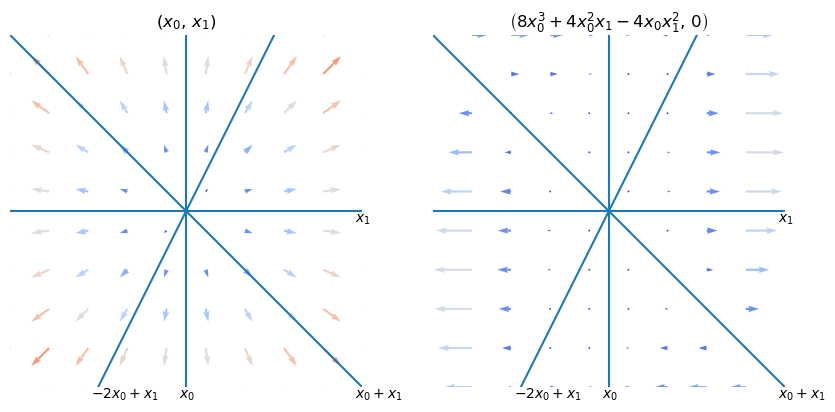

In [13]:
A=HyperPlaneArr([[1,0],[0,1],[1,1],[-2,1]])
MG = A.minimal_generators
# MG is obtained by the splitting: Euler + {vect. field having no y-component}
print(factor(MG[1][0])) # this is a polynomial vanishing along all the planes
fig,axs = plt.subplots(1,len(MG),figsize=(5*len(MG),5))
for i,u in enumerate(MG):
    A.plot_vfield(u,nx=10,ny=10,xlim=(-2,2),ylim=(-2,2),ax=axs[i],quiver=True)

<Axes: title={'center': '$(x_{0})(x_{1})(x_{0} + x_{1})(-2 x_{0} + x_{1})$'}>

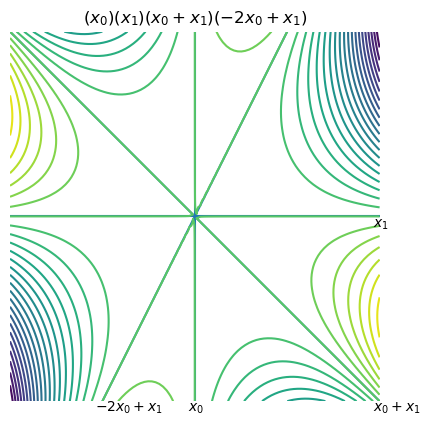

In [38]:
# contour of the defining polynomial
A.plot_arr(levels=30,xlim=(-1,1),ylim=(-1,1))

### n=3

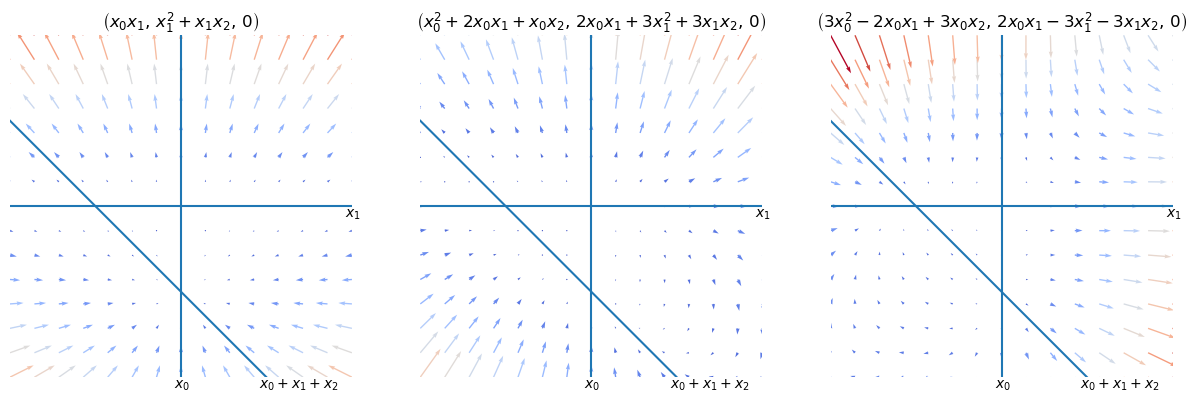

In [40]:
# for n=3, the z-component is made zero by the splitting
A=HyperPlaneArr([[1,0,0],[0,1,0],[0,0,1],[1,1,1]])
#A=matrix(K,[[1,0],[0,1],[1,1]])
MG = A.minimal_generators[1:] # except for euler
fig,axs = plt.subplots(1,len(MG),figsize=(5*len(MG),5))
for i,u in enumerate(MG):
    A.plot_vfield(u,ax=axs[i],xlim=(-2,2),ylim=(-2,2),nx=15,ny=15)


<Axes: title={'center': '$(x_{0})(x_{1})(x_{2})(x_{0} + x_{1} + x_{2})$'}>

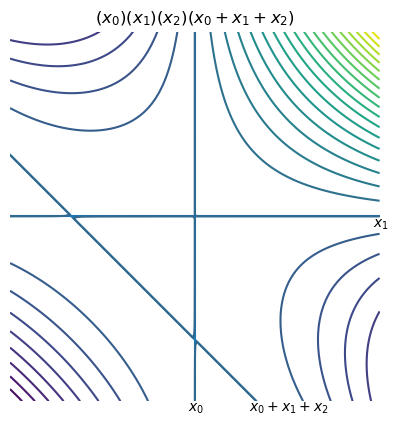

In [41]:
A.plot_arr(levels=30,xlim=(-1.5,1.5),ylim=(-1.5,1.5))

## Finding a free arrangement containing a given one

In [25]:
# there are many free additions due to symmetry
A=HyperPlaneArr([[1,0,0],[0,1,0],[0,0,1],[1,1,1]])
A.minimal_generators,A.is_SPOG()


([(x0, x1, x2),
  (4*x0*x1, 4*x1^2 + 4*x1*x2, 0),
  (x0^2 + 2*x0*x1 + x0*x2, 2*x0*x1 + 3*x1^2 + 3*x1*x2, 0),
  (3*x0^2 - 2*x0*x1 + 3*x0*x2, 2*x0*x1 - 3*x1^2 - 3*x1*x2, 0)],
 [1, 2, 2, 2])

In [26]:
# one of them is [1,0,-1]
LHS,RHS = A.level_coeff()
print(f"level coeff: {LHS[0]}")
print(f"level gen: {LHS[2]}")


level coeff: x0 + 3*x2
level gen: (4*x0*x1, 4*x1^2 + 4*x1*x2, 0)


In [27]:
# by symmetry, any permutation of [1,0,1] would make free addition
B=A.addition(vector([1,0,1]))
C=A.addition([1,1,0])
degseq(B.minimal_generators),degseq(C.minimal_generators)

([1, 2, 2], [1, 2, 2])

In [28]:
A=HyperPlaneArr([[1,0,0],[0,1,0],[0,0,1],[1,1,1]])
print(A.is_SPOG())
LHS,RHS = A.level_coeff()
print(f"level coeff: {LHS[0]}")
print(f"level gen: {LHS[2]}")
LHS[0]*LHS[2], sum(c[0]*c[2] for c in RHS) # these should be equal

[1, 2, 2, 2]
level coeff: x0 + 3*x2
level gen: (4*x0*x1, 4*x1^2 + 4*x1*x2, 0)


((4*x0^2*x1 + 12*x0*x1*x2, 4*x0*x1^2 + 4*x0*x1*x2 + 12*x1^2*x2 + 12*x1*x2^2, 0),
 (4*x0^2*x1 + 12*x0*x1*x2, 4*x0*x1^2 + 4*x0*x1*x2 + 12*x1^2*x2 + 12*x1*x2^2, 0))

In [29]:
# relations between generators
RM=Sequence([module_elem(A.S**A.n,tuple(A.minimal_generators[i])) for i in range(1,len(A.minimal_generators))])
G=syz(RM)
G

[(x0 + 3*x2, -x1 - 3*x2, -x1 + x2)]

In [30]:
A=HyperPlaneArr(identity_matrix(QQ,3).stack(matrix([[1 ,1, 0],[0 ,1, -1],[1 ,1, 1],[1 ,1, 2],[1,1,-2],[1,-1,0]])))
print(A.is_SPOG())
LHS,RHS = A.level_coeff()
print(f"level coeff: {LHS[0]}")
print(f"level gen: {LHS[2]}")


[1, 4, 5, 5]
level coeff: x0 - 7*x1 + 7*x2
level gen: (18*x0^4*x1 + 45*x0^3*x1^2 + 54*x0^2*x1^3 + 27*x0*x1^4 - 18*x0^4*x2 - 27*x0^3*x1*x2 - 9*x0^2*x1^2*x2 - 18*x0*x1^3*x2 - 18*x0^3*x2^2 - 117*x0^2*x1*x2^2 - 81*x0*x1^2*x2^2 + 72*x0^2*x2^3 + 72*x0*x2^4, 27*x0^3*x1^2 + 54*x0^2*x1^3 + 45*x0*x1^4 + 18*x1^5 - 27*x0^3*x1*x2 - 45*x0^2*x1^2*x2 - 9*x0^2*x1*x2^2 - 117*x0*x1^2*x2^2 - 90*x1^3*x2^2 + 72*x0*x1*x2^3 + 72*x1*x2^4, 0)


In [71]:
# adding the level coeff does not make it free
B=A.addition([-1,7,-7])
B.degs

[1, 5, 6, 6, 7]

In [72]:
# search free addition: it seems there is a unique plane
plane = A.search_free_addition(a_range=range(-10,10),b_range=range(-10,10))

  0%|          | 0/20 [00:00<?, ?it/s]

plane:  (1, 1, -1) degrees:  [1, 4, 5]


In [73]:
# arrangement with no free addition
A=HyperPlaneArr(coord_vec(3)+[[1 ,1, 0],[1,3,1],[0 ,3, 1],[0 ,2, 1],[0,1,1],[0,1,-1],[0,1,2]])
A.degs

[1, 3, 6]

In [74]:
# in this case, the level coeff ([-1,0,0]) is already in the arrangement
# this gives a counter-example to "SPOG => NT-free minus"
B=A.deletion([1,5])
print(B.is_SPOG())
LHS,RHS = B.level_coeff()
print(f"level coeff: {LHS[0]}")
print(f"level gen: {LHS[2]}")
B.free_resolution()


[1, 3, 5, 6]
level coeff: -x0
level gen: (12*x0*x1^5 - 8*x0^2*x1^3*x2 + 36*x0*x1^4*x2 - 16*x0^2*x1^2*x2^2 + 19*x0*x1^3*x2^2 + 8*x0^2*x1*x2^3 - 22*x0*x1^2*x2^3 + 16*x0^2*x2^4 - 31*x0*x1*x2^4 - 14*x0*x2^5, 12*x1^6 - 10*x0*x1^4*x2 + 34*x1^5*x2 - 25*x0*x1^3*x2^2 + 10*x1^4*x2^2 - 30*x1^3*x2^3 + 25*x0*x1*x2^4 - 22*x1^2*x2^4 + 10*x0*x2^5 - 4*x1*x2^5, 0)


S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-3)⊕S(-6)⊕S(-5) <-- S(-7) <-- 0

[1, 3, 6]
[1, 3, 5, 6]
[1, 3, 5, 6]
level coeff: -x1 - x2
level gen: (3888*x0^6 + 23328*x0^5*x1 + 12960*x0^4*x1^2 - 38880*x0^3*x1^3 - 38880*x0^2*x1^4 - 8112*x0*x1^5 + 12312*x0^5*x2 + 9720*x0^4*x1*x2 - 27648*x0^3*x1^2*x2 - 30816*x0^2*x1^3*x2 - 10112*x0*x1^4*x2 + 432*x1^5*x2 + 288*x0^3*x1*x2^2 - 384*x0^2*x1^2*x2^2 - 144*x0*x1^3*x2^2 + 432*x1^4*x2^2 - 1224*x0^3*x2^3 + 888*x0^2*x1*x2^3 + 3288*x0*x1^2*x2^3 + 2208*x0^2*x2^4 + 856*x0*x1*x2^4 + 720*x0*x2^5, 7776*x0^5*x1 + 34344*x0^4*x1^2 + 16200*x0^3*x1^3 - 48600*x0^2*x1^4 - 46008*x0*x1^5 - 9408*x1^6 + 7776*x0^5*x2 + 35640*x0^4*x1*x2 + 19872*x0^3*x1^2*x2 - 46008*x0^2*x1^3*x2 - 48312*x0*x1^4*x2 - 15080*x1^5*x2 + 1296*x0^4*x2^2 + 3672*x0^3*x1*x2^2 + 1368*x0^2*x1^2*x2^2 - 3624*x0*x1^3*x2^2 - 2520*x1^4*x2^2 - 1224*x0^2*x1*x2^3 + 888*x0*x1^2*x2^3 + 3288*x1^3*x2^3 + 2208*x0*x1*x2^4 + 856*x1^2*x2^4 + 720*x1*x2^5, 0)


  0%|          | 0/40 [00:00<?, ?it/s]

No planes found


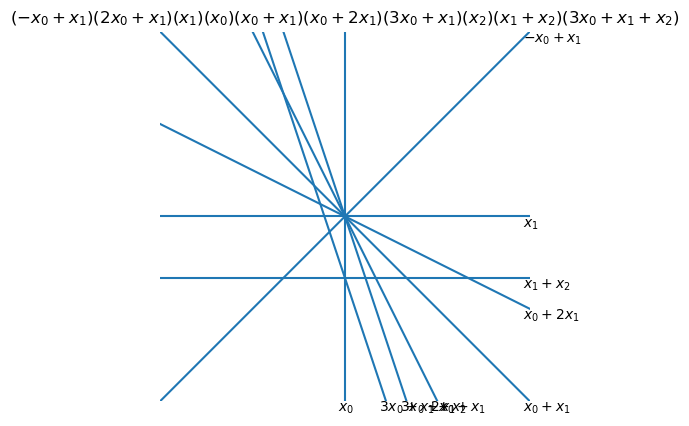

In [118]:
# from "Logarithmic derivation module for a free hyperlane arrangement minus two planes" by J. Chu 
A=HyperPlaneArr([[-1,1,0],[2,1,0],[0,1,0],[1,0,0],[1 ,1, 0],[1,2,0],[3,1,0],[0,0,1],[0,1,1],[3,1,1]])
A.plot_arr(xlim=(-3,3),ylim=(-3,3))
print(A.degs)
B=A.deletion([2,3])
print(B.degs)
print(B.is_SPOG())
LHS,RHS = B.level_coeff()
print(f"level coeff: {LHS[0]}")
#print(f"level gen: {LHS[2]}")
plane = B.search_free_addition(a_range=range(-20,20),b_range=range(-20,20))

In [63]:
# the level element is always S-dependent to other generators minus Euler
print(is_S_indep([B.minimal_generators[i] for i in [1,2,3]]))
det(saito([B.minimal_generators[i] for i in [1,2,3]]))

False


0

## Examples in "Logarithmic derivation module for a free hyperlane arrangement minus two planes" by J. Chu 

### dimension 3

10 [1, 3, 6]
B: 0 [1, 3, 6, 6]
B: 1 [1, 3, 6, 6]
B: 2 [1, 2, 6]
B: 3 [1, 3, 5]
B: 4 [1, 3, 5]
B: 5 [1, 3, 5]
B: 6 [1, 3, 5]
B: 7 [1, 3, 6, 6]
B: 8 [1, 2, 6]
B: 9 [1, 2, 6]


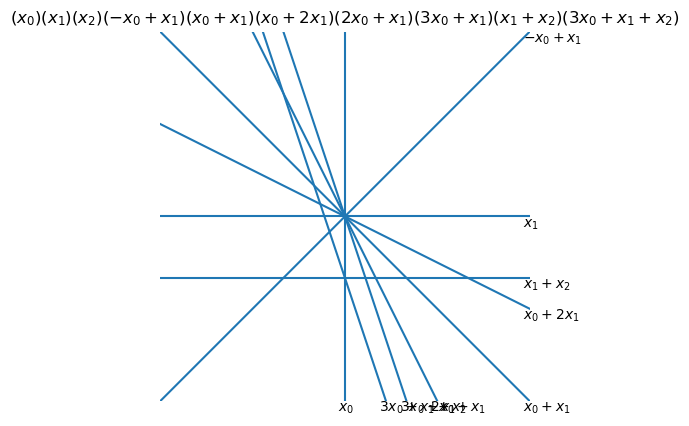

In [363]:
#A=HyperPlaneArr([[0,0,1],[1,0,0],[0,1,0],[1 ,0, 1],[1 ,1, 0],[1,-1,0],[0 ,1, 1],[-1 ,0, 1],[1 ,1, 1],[1 ,-2, 1],[1,2,1]])
#A=HyperPlaneArr([[1,0,0],[0,1,0],[0,0,1],[1 ,1, 0],[0 ,1, 1],[0 ,1, -1],[1 ,0, 1],[1,-1,0],[1 ,1, 1],[1,1,-2],[1 ,1, 2]])
A=HyperPlaneArr([[1,0,0],[0,1,0],[0,0,1],[-1 ,1, 0],[1,1,0],[1,2,0],[2,1,0],[3,1,0],[0,1,1],[3,1,1]])
A.plot_arr(xlim=(-3,3),ylim=(-3,3))
print(A.num_planes,A.degs)
SPOGs = []
for i in range(A.num_planes):
    B=A.deletion([i])
    print('B:',i,B.degs)
    if B.is_SPOG():
        SPOGs.append(i)

In [189]:
LL = list(itertools.combinations(range(A.num_planes),2))
results = {}
for i,j in tqdm(LL):
    B=A.deletion([i,j])
    results[(i,j)]=B.degs
    if B.is_SPOG() and (i in SPOGs) and (j in SPOGs):
        LHS,RHS = B.level_coeff()
        print(f"SPOG:",(i,j),B.degs, f"level coeff: {LHS[0]}")
    elif B.is_free:
        print('free: ',(i,j),B.degs)
    else:
        st = f"pd={len(B.free_resolution())-1}"
        print(st,(i,j),B.degs)


  0%|          | 0/45 [00:00<?, ?it/s]

SPOG: (0, 1) [1, 3, 5, 6] level coeff: -x1 - x2
pd=1 (0, 2) [1, 2, 6, 6]
pd=1 (0, 3) [1, 3, 5, 5]
pd=1 (0, 4) [1, 3, 5, 5]
pd=1 (0, 5) [1, 3, 5, 5]
pd=1 (0, 6) [1, 3, 5, 5]
SPOG: (0, 7) [1, 3, 5, 6] level coeff: -3*x0 - x1 - x2
free:  (0, 8) [1, 2, 5]
free:  (0, 9) [1, 2, 5]
free:  (1, 2) [1, 2, 5]
pd=1 (1, 3) [1, 3, 5, 5]
pd=1 (1, 4) [1, 3, 5, 5]
pd=1 (1, 5) [1, 3, 5, 5]
pd=1 (1, 6) [1, 3, 5, 5]
SPOG: (1, 7) [1, 3, 5, 6] level coeff: 216*x2
free:  (1, 8) [1, 2, 5]
pd=1 (1, 9) [1, 2, 6, 6]
free:  (2, 3) [1, 2, 5]
free:  (2, 4) [1, 2, 5]
free:  (2, 5) [1, 2, 5]
free:  (2, 6) [1, 2, 5]
free:  (2, 7) [1, 2, 5]
free:  (2, 8) [1, 1, 6]
free:  (2, 9) [1, 1, 6]
free:  (3, 4) [1, 3, 4]
free:  (3, 5) [1, 3, 4]
free:  (3, 6) [1, 3, 4]
pd=1 (3, 7) [1, 3, 5, 5]
free:  (3, 8) [1, 2, 5]
free:  (3, 9) [1, 2, 5]
free:  (4, 5) [1, 3, 4]
free:  (4, 6) [1, 3, 4]
pd=1 (4, 7) [1, 3, 5, 5]
free:  (4, 8) [1, 2, 5]
free:  (4, 9) [1, 2, 5]
free:  (5, 6) [1, 3, 4]
pd=1 (5, 7) [1, 3, 5, 5]
free:  (5, 8) [1, 2, 5

In [203]:
for i in range(A.num_planes):
    print(f"\nLooking at {i}-th plane")
    B=A.deletion([i])
    if B.is_free:
        print(f"del {i} is free",B.degs)
    else:
        C=A.restriction(i)
        print(f"Res to {i} free?: {C.is_free}, {C.degs}")
        for j in range(i+1,A.num_planes):        
            B=A.deletion([i,j])
            results[(i,j)]=B.degs
            if B.is_SPOG():
                #LHS,RHS = B.level_coeff()
                print('SPOG:',(i,j),B.degs)#, f"level coeff: {LHS[0]}")
            elif B.is_free:
                print('free: ',(i,j),B.degs)
            else:
                st = f"pd={len(B.free_resolution())-1}"
                print(st,(i,j),B.degs)



Looking at 0-th plane
Res to 0 free?: True, [1, 2]
SPOG: (0, 1) [1, 3, 5, 6]
SPOG: (0, 2) [1, 2, 6, 6]
SPOG: (0, 3) [1, 3, 5, 5]
SPOG: (0, 4) [1, 3, 5, 5]
SPOG: (0, 5) [1, 3, 5, 5]
SPOG: (0, 6) [1, 3, 5, 5]
SPOG: (0, 7) [1, 3, 5, 6]
free:  (0, 8) [1, 2, 5]
free:  (0, 9) [1, 2, 5]

Looking at 1-th plane
Res to 1 free?: True, [1, 2]
free:  (1, 2) [1, 2, 5]
SPOG: (1, 3) [1, 3, 5, 5]
SPOG: (1, 4) [1, 3, 5, 5]
SPOG: (1, 5) [1, 3, 5, 5]
SPOG: (1, 6) [1, 3, 5, 5]
SPOG: (1, 7) [1, 3, 5, 6]
free:  (1, 8) [1, 2, 5]
SPOG: (1, 9) [1, 2, 6, 6]

Looking at 2-th plane
del 2 is free [1, 2, 6]

Looking at 3-th plane
del 3 is free [1, 3, 5]

Looking at 4-th plane
del 4 is free [1, 3, 5]

Looking at 5-th plane
del 5 is free [1, 3, 5]

Looking at 6-th plane
del 6 is free [1, 3, 5]

Looking at 7-th plane
Res to 7 free?: True, [1, 2]
SPOG: (7, 8) [1, 2, 6, 6]
free:  (7, 9) [1, 2, 5]

Looking at 8-th plane
del 8 is free [1, 2, 6]

Looking at 9-th plane
del 9 is free [1, 2, 6]


### dimension 4

In [3]:
mat=[[ 1,  0,  0,  0],
[ 0,  1,  0,  0],
[ 0,  0,  1,  0],
[-1,  1,  0,  0],
[-1,  0,  1,  0],
[ 0, -1,  1,  0],
[ 0,  0,  0,  1],
[ 0,  1, -1,  1],
[-1,  1, -1,  1],
[ 0,  0, -1,  1]]
A=HyperPlaneArr(mat)
print(f"Num of planes: {A.num_planes}, Deg. Seq. {A.degs}")
A.free_resolution()


Num of planes: 10, Deg. Seq. [1, 3, 3, 3]


S(0)⊕S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-3)⊕S(-3)⊕S(-3) <-- 0

In [4]:
# example for (d_1,...,d_l,c_1,c_2) is a proper subseq. of the degree seq.
B=A.deletion([2,9])
print(f"Num of planes: {B.num_planes}, Deg. Seq. {B.degs}")
B.free_resolution()


Num of planes: 8, Deg. Seq. [1, 3, 3, 3, 3, 3, 3]


S(0)⊕S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-3)⊕S(-3)⊕S(-3)⊕S(-3)⊕S(-3)⊕S(-3) <-- S(-4)⊕S(-4)⊕S(-4)⊕S(-4) <-- S(-5) <-- 0

In [236]:
# list all minus-two
## restriction to both 0 and 2 are free, but minus {0,2} has more generators than dim+2
for i in range(A.num_planes):
    print(f"\nLooking at {i}-th plane")
    B=A.deletion([i])
    print(f"del {i} degrees: {B.degs}, is SPOG: {B.is_SPOG()}")
    C=A.restriction(i)
    print(f"Res to {i} free?: {C.is_free}, {C.degs}, is SPOG: {C.is_SPOG()}")
    if B.is_free:
        print(f"del {i} is free")
    else:
        for j in range(i+1,A.num_planes):        
            B=A.deletion([i,j])
            results[(i,j)]=B.degs
            if B.is_SPOG():
                #LHS,RHS = B.level_coeff()
                print('SPOG: del',(i,j),B.degs)#, f"level coeff: {LHS[0]}")
            elif B.is_free:
                print('free: del',(i,j),B.degs)
            else:
                st = f"pd={len(B.free_resolution())-1}"
                print(st," del",(i,j),B.degs)


Looking at 0-th plane
del 0 degrees: [1, 3, 3, 3, 3], is SPOG: [1, 3, 3, 3, 3]
Res to 0 free?: True, [1, 2, 3], is SPOG: False
SPOG: del (0, 1) [1, 2, 3, 3, 3]
pd=2  del (0, 2) [1, 3, 3, 3, 3, 3, 3]
SPOG: del (0, 3) [1, 2, 3, 3, 3]
free: del (0, 4) [1, 2, 2, 3]
pd=1  del (0, 5) [1, 3, 3, 3, 3, 3]
SPOG: del (0, 6) [1, 2, 3, 3, 3]
pd=2  del (0, 7) [1, 3, 3, 3, 3, 3, 3]
free: del (0, 8) [1, 2, 2, 3]
pd=1  del (0, 9) [1, 3, 3, 3, 3, 3]

Looking at 1-th plane
del 1 degrees: [1, 3, 3, 3, 3], is SPOG: [1, 3, 3, 3, 3]
Res to 1 free?: False, [1, 3, 3, 3], is SPOG: [1, 3, 3, 3]
SPOG: del (1, 2) [1, 2, 3, 3, 3]
SPOG: del (1, 3) [1, 2, 3, 3, 3]
SPOG: del (1, 4) [1, 2, 3, 3, 3]
SPOG: del (1, 5) [1, 2, 3, 3, 3]
SPOG: del (1, 6) [1, 2, 3, 3, 3]
SPOG: del (1, 7) [1, 2, 3, 3, 3]
SPOG: del (1, 8) [1, 2, 3, 3, 3]
SPOG: del (1, 9) [1, 2, 3, 3, 3]

Looking at 2-th plane
del 2 degrees: [1, 3, 3, 3, 3], is SPOG: [1, 3, 3, 3, 3]
Res to 2 free?: True, [1, 2, 3], is SPOG: False
pd=1  del (2, 3) [1, 3, 3, 3, 3,

In [216]:
#another example for (d_1,...,d_l,c_1,c_2) is a proper subseq. of the degree seq.
mat=[[1,0,0,0],[1,1,0,0],[1,0,1,0],[1,0,0,1],[1,-1,0,0],[1,0,-1,0],[1,0,0,-1],[0,1,-1,0],[0,0,1,-1],[0,1,0,1]]
A=HyperPlaneArr(mat)
print(f"A: Num of planes: {A.num_planes}, Deg. Seq. {A.degs}")
print(A.free_resolution(),"\n")
B=A.deletion([1,2])
print(f"B: Num of planes: {B.num_planes}, Deg. Seq. {B.degs}")
B.free_resolution()


A: Num of planes: 10, Deg. Seq. [1, 3, 3, 3]
S(0)⊕S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-3)⊕S(-3)⊕S(-3) <-- 0 

B: Num of planes: 8, Deg. Seq. [1, 3, 3, 3, 3, 3, 3]


S(0)⊕S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-3)⊕S(-3)⊕S(-3)⊕S(-3)⊕S(-3)⊕S(-3) <-- S(-4)⊕S(-4)⊕S(-4)⊕S(-4) <-- S(-5) <-- 0

In [175]:
B=A.deletion([1,2])
print(f"B: Num of planes: {B.num_planes}, Deg. Seq. {B.degs}")
B.free_resolution()


B: Num of planes: 8, Deg. Seq. [1, 3, 3, 3, 3, 3, 3]


S(0)⊕S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-3)⊕S(-3)⊕S(-3)⊕S(-3)⊕S(-3)⊕S(-3) <-- S(-4)⊕S(-4)⊕S(-4)⊕S(-4) <-- S(-5) <-- 0

In [172]:
mat=coord_vec(4)+[[1 ,-1,0, 0],[1,0 ,-1, 0],[1,0,0,-1],[0 ,1, -1,0],[0,1 ,0, -1],[0,0,1,-1],[0,1 ,-1, 1],[1,-1,1,-1]]
A=HyperPlaneArr(mat)
print(f"A: Num of planes: {A.num_planes}, Deg. Seq. {A.degs}")
print(A.free_resolution(),"\n")
B=A.deletion([0,1])
print(f"B: Num of planes: {B.num_planes}, Deg. Seq. {B.degs}")
print(B.free_resolution(),"\n")
B1=A.deletion([0,7])
print(f"B1: Num of planes: {B1.num_planes}, Deg. Seq. {B1.degs}")
print(B1.free_resolution(),"\n")
B2=A.deletion([1,9])
print(f"B2: Num of planes: {B2.num_planes}, Deg. Seq. {B2.degs}")
print(B2.free_resolution())


A: Num of planes: 12, Deg. Seq. [1, 3, 4, 4]
S(0)⊕S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-3)⊕S(-4)⊕S(-4) <-- 0 

B: Num of planes: 10, Deg. Seq. [1, 3, 3, 4, 4]
S(0)⊕S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-3)⊕S(-4)⊕S(-4)⊕S(-3) <-- S(-5) <-- 0 

B1: Num of planes: 10, Deg. Seq. [1, 3, 4, 4, 4, 5]
S(0)⊕S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-3)⊕S(-4)⊕S(-4)⊕S(-5)⊕S(-4) <-- S(-5)⊕S(-6) <-- 0 

B2: Num of planes: 10, Deg. Seq. [1, 3, 4, 4, 4, 4]
S(0)⊕S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-3)⊕S(-4)⊕S(-4)⊕S(-4)⊕S(-4) <-- S(-5)⊕S(-5) <-- 0


In [28]:
# list all minus-two
## note: when multi-restriction is non-free, pd<2.
results = {}
for i in range(A.num_planes):
    print(f"\nLooking at {i}-th plane")
    B=A.deletion([i])
    print(f"del {i} degrees: ",B.degs)
    C=A.restriction(i)
    print(f"Res to {i} free?: {C.is_free}, {C.degs}, is SPOG: {C.is_SPOG()},")
    if B.is_free:
        print(f"del {i} is free")
    else:
        for j in range(i+1,A.num_planes):        
            B=A.deletion([i,j])
            results[(i,j)]=B.degs
            prt = ""
            if B.is_SPOG():
                #LHS,RHS = B.level_coeff()
                prt += f'SPOG: del {(i,j)}\n\tdegs {str(B.degs):<25}' #, f"level coeff: {LHS[0]}")
            elif B.is_free:
                prt += f'free: del {(i,j)}\n\tdegs {str(B.degs):<25}'
            else:
                prt += f'pd={len(B.free_resolution())-1}: del {(i,j)}\n\tdegs {str(B.degs):<25}'
            
            prt += f'localisation {str(A.localisation([i,j]).degs):<25}\n'
            Aij = A.deletion([i]).restriction(j-1)
            Aji = A.deletion([j]).restriction(i)
            prt += f'\trestriction A_i^j {str(Aij.degs):<25}'
            prt += f'A_j^i {str(Aji.degs):<25}\n'
            prt += f'\tmulti-restriction A_i^j {str(degseq(Aij.compute_multi_minimal_generators())):<25}'
            prt += f'A_j^i {str(degseq(Aji.compute_multi_minimal_generators())):<25}'
            print(prt)


Looking at 0-th plane
del 0 degrees:  [1, 3, 3, 3, 3]
Res to 0 free?: True, [1, 2, 3], is SPOG: False,
SPOG: del (0, 1)
	degs [1, 2, 3, 3, 3]          localisation [0, 0, 1, 2]             
	restriction A_i^j [1, 3, 3, 3]             A_j^i [1, 2, 3]                
	multi-restriction A_i^j [3, 3, 3, 3]             A_j^i [3, 3, 3, 3]             
pd=2: del (0, 2)
	degs [1, 3, 3, 3, 3, 3, 3]    localisation [0, 0, 1, 2]             
	restriction A_i^j [1, 2, 3]                A_j^i [1, 2, 3]                
	multi-restriction A_i^j [2, 3, 3]                A_j^i [2, 3, 3]                
SPOG: del (0, 3)
	degs [1, 2, 3, 3, 3]          localisation [0, 0, 1, 2]             
	restriction A_i^j [1, 2, 3]                A_j^i [1, 2, 3]                
	multi-restriction A_i^j [3, 3, 3, 3]             A_j^i [3, 3, 3, 3]             
free: del (0, 4)
	degs [1, 2, 2, 3]             localisation [0, 0, 1, 2]             
	restriction A_i^j [1, 3, 3]                A_j^i [1, 2, 3]               

In [8]:
# list all minus-two
## note: when multi-restriction is non-free, pd<2.
#mat=coord_vec(4)+[[1 ,-1,0, 0],[1,0 ,-1, 0],[1,0,0,-1],[0 ,1, -1,0],[0,1 ,0, -1],[0,0,1,-1],[0,1 ,-1, 1],[1,-1,1,-1]]
mat=[[1,0,0,0],[1,1,0,0],[1,0,1,0],[1,0,0,1],[1,-1,0,0],[1,0,-1,0],[1,0,0,-1],[0,1,-1,0],[0,0,1,-1],[0,1,0,1]]

A=HyperPlaneArr(mat)
results = {}
for i in range(A.num_planes):
    print(f"\nLooking at {i}-th plane")
    B=A.deletion([i])
    print(f"del {i} degrees: ",B.degs)
    C=A.restriction(i)
    print(f"Res to {i} free?: {C.is_free}, {C.degs}, is SPOG: {C.is_SPOG()},")
    if B.is_free:
        print(f"del {i} is free")
    else:
        for j in range(i+1,A.num_planes):        
            B=A.deletion([i,j])
            results[(i,j)]=B.degs
            prt = ""
            if B.is_SPOG():
                #LHS,RHS = B.level_coeff()
                prt += f'SPOG: del {(i,j)}\n\tdegs {str(B.degs):<25}' #, f"level coeff: {LHS[0]}")
            elif B.is_free:
                prt += f'free: del {(i,j)}\n\tdegs {str(B.degs):<25}'
            else:
                prt += f'pd={len(B.free_resolution())-1}: del {(i,j)}\n\tdegs {str(B.degs):<25}'
            
            prt += f'localisation {str(A.localisation([i,j]).degs):<25}\n'
            Aij = A.deletion([i]).restriction(j-1)
            Aji = A.deletion([j]).restriction(i)
            prt += f'\trestriction A_i^j {str(Aij.degs):<25}'
            prt += f'A_j^i {str(Aji.degs):<25}\n'
            prt += f'\tmulti-restriction A_i^j {str(degseq(Aij.compute_multi_minimal_generators())):<25}'
            prt += f'A_j^i {str(degseq(Aji.compute_multi_minimal_generators())):<25}'
            print(prt)


Looking at 0-th plane
del 0 degrees:  [1, 3, 3, 3, 3]
Res to 0 free?: False, [1, 3, 3, 3], is SPOG: [1, 3, 3, 3],
SPOG: del (0, 1)
	degs [1, 2, 3, 3, 3]          localisation [0, 0, 1, 2]             
	restriction A_i^j [1, 2, 3]                A_j^i [1, 3, 3, 3]             
	multi-restriction A_i^j [3, 3, 3, 3]             A_j^i [3, 3, 3, 3]             
SPOG: del (0, 2)
	degs [1, 2, 3, 3, 3]          localisation [0, 0, 1, 2]             
	restriction A_i^j [1, 2, 3]                A_j^i [1, 3, 3, 3]             
	multi-restriction A_i^j [3, 3, 3, 3]             A_j^i [3, 3, 3, 3]             
SPOG: del (0, 3)
	degs [1, 2, 3, 3, 3]          localisation [0, 0, 1, 2]             
	restriction A_i^j [1, 2, 3]                A_j^i [1, 3, 3, 3]             
	multi-restriction A_i^j [3, 3, 3, 3]             A_j^i [3, 3, 3, 3]             
SPOG: del (0, 4)
	degs [1, 2, 3, 3, 3]          localisation [0, 0, 1, 2]             
	restriction A_i^j [1, 2, 3]                A_j^i [1, 3, 3, 3] 

### Ziegler's restriction (multi-restriction)

In [3]:
mat=[[ 1,  0,  0,  0],
[ 0,  1,  0,  0],
[ 0,  0,  1,  0],
[-1,  1,  0,  0],
[-1,  0,  1,  0],
[ 0, -1,  1,  0],
[ 0,  0,  0,  1],
[ 0,  1, -1,  1],
[-1,  1, -1,  1],
[ 0,  0, -1,  1]]
A=HyperPlaneArr(mat)
print(f"A: Num of planes: {A.num_planes}, Deg. Seq. {A.degs}")

A: Num of planes: 10, Deg. Seq. [1, 3, 3, 3]


In [4]:
# note that the indices will shift after deletion. 
# so here we are removing H0 and then restricting to H2 in the original arr.
B=A.deletion([0]).restriction(1)
print(B.multiplicity)
print(B.degs)
MG = B.compute_multi_minimal_generators()
degseq(MG), MG

[2, 1, 1, 2, 1, 1]
[1, 2, 3]


([2, 3, 3],
 [(x0^2 - 2*x0*x1, -x1^2, x2^2),
  (x0^2*x2 - x0*x1*x2, 0, x1*x2^2 + x2^3),
  (x0^3 - 2*x0^2*x1 + x0*x1^2 - x0^2*x2 + x0*x1*x2, 0, 0)])

In [4]:
B=A.deletion([2]).restriction(0)
print(B.multiplicity)
print(B.degs)
MG = B.compute_multi_minimal_generators()
degseq(MG), MG

[2, 1, 1, 1, 2, 1]
[1, 2, 3]


([2, 3, 3],
 [(x0^2, 2*x0*x1 - x1^2, 2*x0*x2 - 2*x1*x2 + x2^2),
  (0, x0*x1*x2 - x1^2*x2, x0*x1*x2 - x1^2*x2),
  (0, x0^2*x1 - 2*x0*x1^2 + x1^3 + 4*x0*x1*x2 - 4*x1^2*x2, x0^2*x2 - x1^2*x2 + 2*x0*x2^2 - 3*x1*x2^2 + x2^3)])

## Same lattice but different degree sequences
degree sequence is in general not combinatorial

S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-5)⊕S(-6)⊕S(-6) <-- S(-8) <-- 0


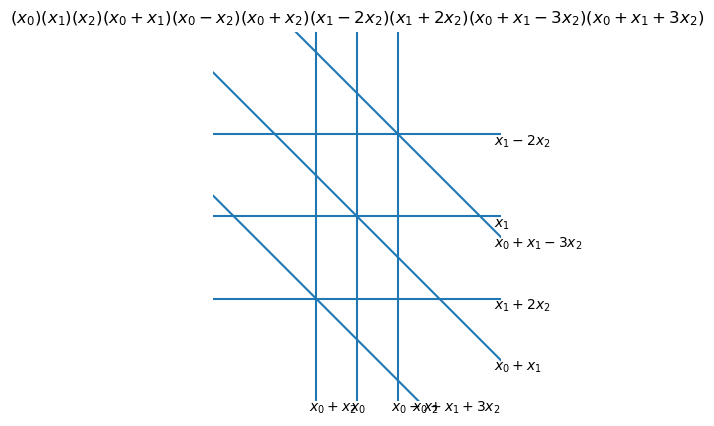

In [124]:
a=2
A=HyperPlaneArr(coord_vec(3)+[[1,1,0],[1,0,-1],[1,0,1],[0,1,-a],[0,1,2],[1,1,-a-1],[1,1,3]])
A.plot_arr(xlim=(-3.5,3.5),ylim=(-4.5,4.5))
A.degs, latex(factor(A.Q),"\n")
print(A.free_resolution())

S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-6)⊕S(-6)⊕S(-6)⊕S(-6)⊕S(-6) <-- S(-7)⊕S(-7)⊕S(-7) <-- 0


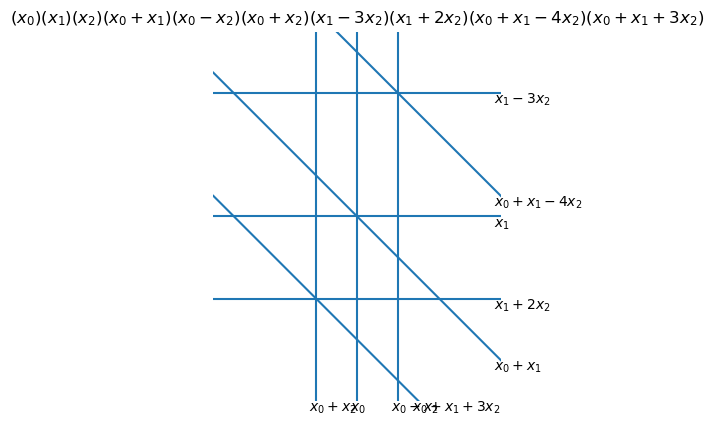

In [127]:
a=3
A=HyperPlaneArr(coord_vec(3)+[[1,1,0],[1,0,-1],[1,0,1],[0,1,-a],[0,1,2],[1,1,-a-1],[1,1,3]])
A.plot_arr(xlim=(-3.5,3.5),ylim=(-4.5,4.5))
A.degs, latex(factor(A.Q),"\n")
print(A.free_resolution())

[1, 5, 6]


  0%|          | 0/12 [00:00<?, ?it/s]

0 [1, 5, 5]
1 [1, 5, 5]
2 [1, 5, 6, 7]
3 [1, 5, 6, 7]
4 [1, 5, 6, 6]
5 [1, 5, 5]
6 [1, 5, 5]
7 [1, 5, 6, 6]
8 [1, 5, 5]
9 [1, 5, 5]
10 [1, 5, 6, 7]
11 [1, 5, 5]


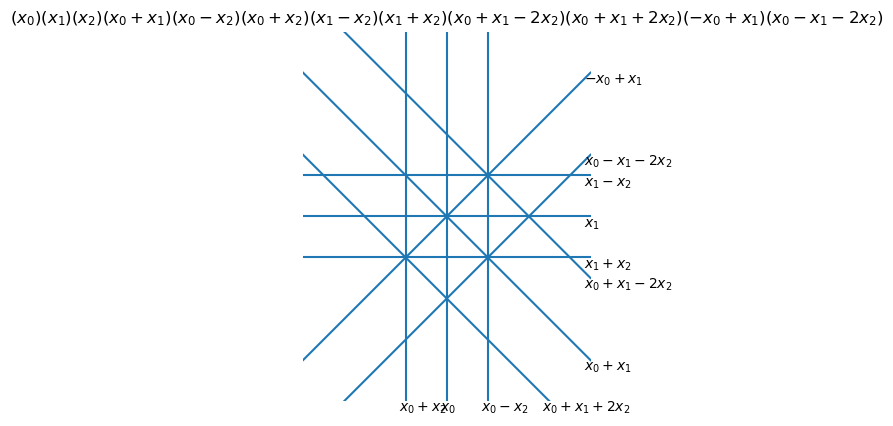

In [99]:
result1 = {}
a=1
mat=matrix(QQ,coord_vec(3)+[[1,1,0],[1,0,-1],[1,0,1],[0,1,-a],[0,1,1],[1,1,-a-1],[1,1,2],[-1,1,0],[1,-1,-2]])
A=HyperPlaneArr(mat)
A.plot_arr(xlim=(-3.5,3.5),ylim=(-4.5,4.5))
print(A.degs)
for i in tqdm(range(mat.nrows())):
    B=A.deletion([i])
    result1[i]=B.degs
    print(i,result1[i])

In [13]:
# Ziegler arrangements
M = [[0,1,0],[2,2,1],[3,1,1],[8,-1,4],[9,3,-1]]
A=HyperPlaneArr(M+[[9,-2,3],[11,2,1],[5,5,-2]],base_field=QQ)
B=HyperPlaneArr(M+[[21,-4,7],[19,4,1],[10,10,-5]],base_field=QQ)

A.degs, B.degs

([1, 5, 5, 5, 5], [1, 5, 5, 5, 6])

<Axes: title={'center': '$(x_{1})(2 x_{0} + 2 x_{1} + x_{2})(3 x_{0} + x_{1} + x_{2})(8 x_{0} - x_{1} + 4 x_{2})(9 x_{0} + 3 x_{1} - x_{2})(21 x_{0} - 4 x_{1} + 7 x_{2})(19 x_{0} + 4 x_{1} + x_{2})(10 x_{0} + 10 x_{1} - 4 x_{2})$'}>

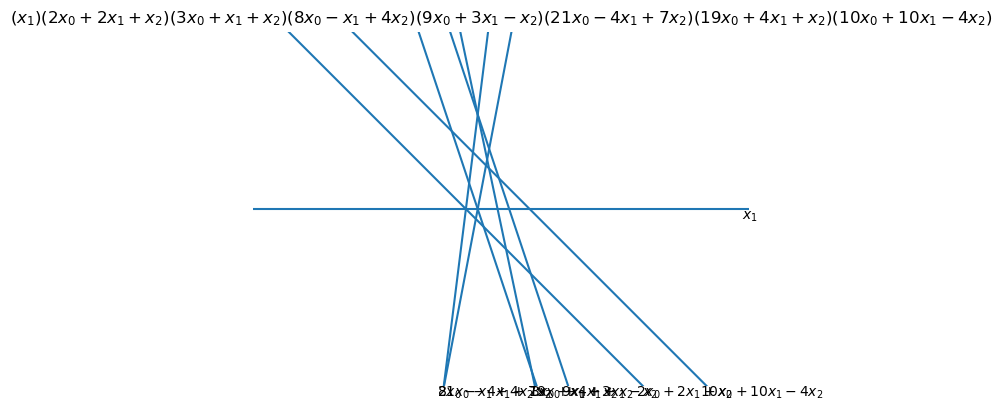

In [16]:
B.plot_arr(xlim=(-3.5,3.5),ylim=(-2.5,2.5))


## Edelman-Reiner’s counter-example to Orlik's conjecture

In [218]:
mat=coord_vec(5)+[[1,1,1,1,1],[1,-1,1,1,1],[1,1,-1,1,1],[1,1,1,-1,1],[1,1,1,1,-1],[1,-1,-1,1,1],[1,-1,1,-1,1],[1,-1,1,1,-1],[1,-1,-1,1,-1],[1,-1,1,-1,-1],[1,-1,-1,-1,1],[1,1,-1,-1,1],[1,1,-1,1,-1],[1,1,-1,-1,-1],[1,1,1,-1,-1],[1,-1,-1,-1,-1]]
A=HyperPlaneArr(mat)

In [156]:
res = list(sage.parallel.multiprocessing_sage.parallel_iter(int(0), list_ntf2, [((i,), {"A":A}) for i in range(A.num_planes-1)]))

pd=1 (0, 1) [1, 5, 5, 5, 5, 8, 8]
pd=1 (0, 2) [1, 5, 5, 5, 5, 8, 8]
pd=1 (0, 3) [1, 5, 5, 5, 5, 8, 8]
pd=1 (0, 4) [1, 5, 5, 5, 5, 8, 8]
pd=1 (0, 5) [1, 5, 5, 5, 5, 5, 7]
pd=1 (0, 6) [1, 5, 5, 5, 5, 5, 7]
pd=1 (0, 7) [1, 5, 5, 5, 5, 5, 7]
pd=1 (0, 8) [1, 5, 5, 5, 5, 5, 7]
pd=1 (0, 9) [1, 5, 5, 5, 5, 5, 7]
pd=1 (0, 10) [1, 5, 5, 5, 5, 5, 7]
pd=1 (0, 11) [1, 5, 5, 5, 5, 5, 7]
pd=1 (0, 12) [1, 5, 5, 5, 5, 5, 7]
pd=1 (0, 13) [1, 5, 5, 5, 5, 5, 7]
pd=1 (0, 14) [1, 5, 5, 5, 5, 5, 7]
pd=1 (0, 15) [1, 5, 5, 5, 5, 5, 7]
pd=1 (0, 16) [1, 5, 5, 5, 5, 5, 7]
pd=1 (0, 17) [1, 5, 5, 5, 5, 5, 7]
pd=1 (0, 18) [1, 5, 5, 5, 5, 5, 7]
pd=1 (0, 19) [1, 5, 5, 5, 5, 5, 7]
pd=1 (0, 20) [1, 5, 5, 5, 5, 5, 7]
pd=1 (1, 2) [1, 5, 5, 5, 5, 8, 8]
pd=1 (1, 3) [1, 5, 5, 5, 5, 8, 8]
pd=1 (1, 4) [1, 5, 5, 5, 5, 8, 8]
pd=1 (1, 5) [1, 5, 5, 5, 5, 5, 7]
pd=1 (1, 6) [1, 5, 5, 5, 5, 5, 7]
pd=1 (1, 7) [1, 5, 5, 5, 5, 5, 7]
pd=1 (1, 8) [1, 5, 5, 5, 5, 5, 7]
pd=1 (1, 9) [1, 5, 5, 5, 5, 5, 7]
pd=1 (1, 10) [1, 5, 5, 5, 5, 5, 7]
pd

[(((0,), {'A': <__main__.HyperPlaneArr object at 0x7f3fab9caf80>}),
  {(0, 1): [1, 5, 5, 5, 5, 8, 8],
   (0, 2): [1, 5, 5, 5, 5, 8, 8],
   (0, 3): [1, 5, 5, 5, 5, 8, 8],
   (0, 4): [1, 5, 5, 5, 5, 8, 8],
   (0, 5): [1, 5, 5, 5, 5, 5, 7],
   (0, 6): [1, 5, 5, 5, 5, 5, 7],
   (0, 7): [1, 5, 5, 5, 5, 5, 7],
   (0, 8): [1, 5, 5, 5, 5, 5, 7],
   (0, 9): [1, 5, 5, 5, 5, 5, 7],
   (0, 10): [1, 5, 5, 5, 5, 5, 7],
   (0, 11): [1, 5, 5, 5, 5, 5, 7],
   (0, 12): [1, 5, 5, 5, 5, 5, 7],
   (0, 13): [1, 5, 5, 5, 5, 5, 7],
   (0, 14): [1, 5, 5, 5, 5, 5, 7],
   (0, 15): [1, 5, 5, 5, 5, 5, 7],
   (0, 16): [1, 5, 5, 5, 5, 5, 7],
   (0, 17): [1, 5, 5, 5, 5, 5, 7],
   (0, 18): [1, 5, 5, 5, 5, 5, 7],
   (0, 19): [1, 5, 5, 5, 5, 5, 7],
   (0, 20): [1, 5, 5, 5, 5, 5, 7]}),
 (((1,), {'A': <__main__.HyperPlaneArr object at 0x7f3fabafad70>}),
  {(1, 2): [1, 5, 5, 5, 5, 8, 8],
   (1, 3): [1, 5, 5, 5, 5, 8, 8],
   (1, 4): [1, 5, 5, 5, 5, 8, 8],
   (1, 5): [1, 5, 5, 5, 5, 5, 7],
   (1, 6): [1, 5, 5, 5, 5, 5, 7],
 

In [160]:
for i in range(A.num_planes):
    B=A.restriction(i)
    print(i,B.is_free)

0 True
1 True
2 True
3 True
4 True
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False


In [ ]:
# list all minus-two
## restriction to both 0 and 2 are free, but minus {0,2} has more generators than dim+2
for i in range(A.num_planes):
    print(f"\nLooking at {i}-th plane")
    B=A.deletion([i])
    print(f"del {i} degrees: ",B.degs)
    C=A.restriction(i)
    print(f"Res to {i} free?: {C.is_free}, {C.degs}, is SPOG: {C.is_SPOG()},")
    if B.is_free:
        print(f"del {i} is free")


## free plus one can have a large PD

In [29]:
mat=coord_vec(5)+[[1,1,1,1,1]]
A=HyperPlaneArr(mat)
A.free_resolution()

S(0)⊕S(0)⊕S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-2)⊕S(-2)⊕S(-2)⊕S(-2)⊕S(-2)⊕S(-2)⊕S(-2)⊕S(-2)⊕S(-2)⊕S(-2) <-- S(-3)⊕S(-3)⊕S(-3)⊕S(-3)⊕S(-3)⊕S(-3)⊕S(-3)⊕S(-3)⊕S(-3)⊕S(-3) <-- S(-4)⊕S(-4)⊕S(-4)⊕S(-4)⊕S(-4) <-- S(-5) <-- 0

In [243]:
mat=coord_vec(5)+[[1,1,1,1,1],[1,-1,1,1,1],[1,1,-1,1,1],[1,1,1,-1,1],[1,1,1,1,-1],[1,-1,-1,1,1],[1,-1,1,-1,1],[1,-1,1,1,-1],[1,-1,-1,1,-1],[1,-1,1,-1,-1],[1,-1,-1,-1,1],[1,1,-1,-1,1],[1,1,-1,1,-1]]
A=HyperPlaneArr(mat)
A.free_resolution()

S(0)⊕S(0)⊕S(0)⊕S(0)⊕S(0) <-- S(-1)⊕S(-4)⊕S(-4)⊕S(-5)⊕S(-5)⊕S(-5) <-- S(-6) <-- 0